In [1]:
# import all necessary libraries
!pip install mysql-connector-python
!pip install vaderSentiment
!pip install tensorflow
!pip install keras
!pip install protobuf
!pip install grpcio
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow
import keras
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time
import json
import re
import math
import pickle
from datetime import datetime
from datetime import timedelta
import requests
from requests.auth import AuthBase
import config
import tools
import mysql.connector
import urllib.parse
from mysql.connector import errorcode
import sqlite3
%matplotlib inline
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

Using TensorFlow backend.


In [30]:
# reload from pickle checkpoint
with open('pickle-folder/tsla_week1_data.pkl', 'rb') as f:
    data = pickle.load(f)
data.head(1000)

,avg_price,compound_sentiment,tweet_count,trade_volume
0,,,,
2020-05-11 05:01:00,819.42000,0.510600,1.0,0.0
2020-05-11 05:02:00,819.42000,0.421500,1.0,0.0
2020-05-11 05:03:00,819.42000,0.421500,0.0,0.0
2020-05-11 05:04:00,819.42000,0.843600,1.0,0.0
2020-05-11 05:05:00,819.42000,-0.125000,2.0,0.0
2020-05-11 05:06:00,819.42000,-0.458800,1.0,0.0
2020-05-11 05:07:00,819.42000,-0.699700,1.0,0.0
2020-05-11 05:08:00,819.42000,0.000000,1.0,0.0
2020-05-11 05:09:00,819.42000,-0.661500,1.0,0.0


# LSTM
- 50-dimensionial single layer
- activation = tanh
- epochs = 20
- batch size = 63
- 2 nights and 2 days of predictions

In [74]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)
print(reframed.head())

     var1(t-270)  var2(t-270)  var3(t-270)  var4(t-270)  var1(t-269)  \
270     0.701208     0.771606     0.045455          0.0     0.701208   
271     0.701208     0.725219     0.045455          0.0     0.701208   
272     0.701208     0.725219     0.000000          0.0     0.701208   
273     0.701208     0.944971     0.045455          0.0     0.701208   
274     0.701208     0.440702     0.090909          0.0     0.701208   

     var2(t-269)  var3(t-269)  var4(t-269)  var1(t-268)  var2(t-268)  \
270     0.725219     0.045455          0.0     0.701208     0.725219   
271     0.725219     0.000000          0.0     0.701208     0.944971   
272     0.944971     0.045455          0.0     0.701208     0.440702   
273     0.440702     0.090909          0.0     0.701208     0.266920   
274     0.266920     0.045455          0.0     0.701208     0.141504   

     var3(t-268)  var4(t-268)  var1(t-267)  var2(t-267)  var3(t-267)  \
270     0.000000          0.0     0.701208     0.944971     0.

In [76]:
# split into train and test sets
values = reframed.values
train_mins = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)


Epoch 1/20
56/56 - 6s - loss: 0.0326 - val_loss: 0.0105
Epoch 2/20
56/56 - 5s - loss: 0.0109 - val_loss: 0.0045
Epoch 3/20
56/56 - 5s - loss: 0.0059 - val_loss: 0.0038
Epoch 4/20
56/56 - 5s - loss: 0.0033 - val_loss: 0.0050
Epoch 5/20
56/56 - 5s - loss: 0.0022 - val_loss: 0.0049
Epoch 6/20
56/56 - 5s - loss: 0.0019 - val_loss: 0.0042
Epoch 7/20
56/56 - 5s - loss: 0.0016 - val_loss: 0.0036
Epoch 8/20
56/56 - 5s - loss: 0.0014 - val_loss: 0.0029
Epoch 9/20
56/56 - 5s - loss: 0.0012 - val_loss: 0.0023
Epoch 10/20
56/56 - 5s - loss: 0.0010 - val_loss: 0.0018
Epoch 11/20
56/56 - 5s - loss: 9.4151e-04 - val_loss: 0.0014
Epoch 12/20
56/56 - 5s - loss: 8.7551e-04 - val_loss: 0.0011
Epoch 13/20
56/56 - 6s - loss: 8.4020e-04 - val_loss: 8.1298e-04
Epoch 14/20
56/56 - 5s - loss: 8.2798e-04 - val_loss: 6.5015e-04
Epoch 15/20
56/56 - 5s - loss: 8.2922e-04 - val_loss: 5.3793e-04
Epoch 16/20
56/56 - 5s - loss: 8.3405e-04 - val_loss: 4.5751e-04
Epoch 17/20
56/56 - 5s - loss: 8.3508e-04 - val_loss: 3.9

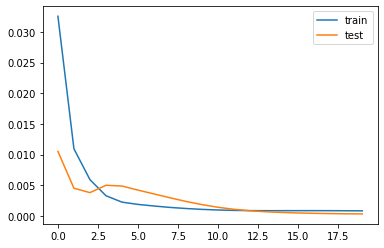

In [77]:
# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [78]:
# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

Test RMSE: 1.316
Test RMSE/std_dev: 0.178
Test MAE: 0.843


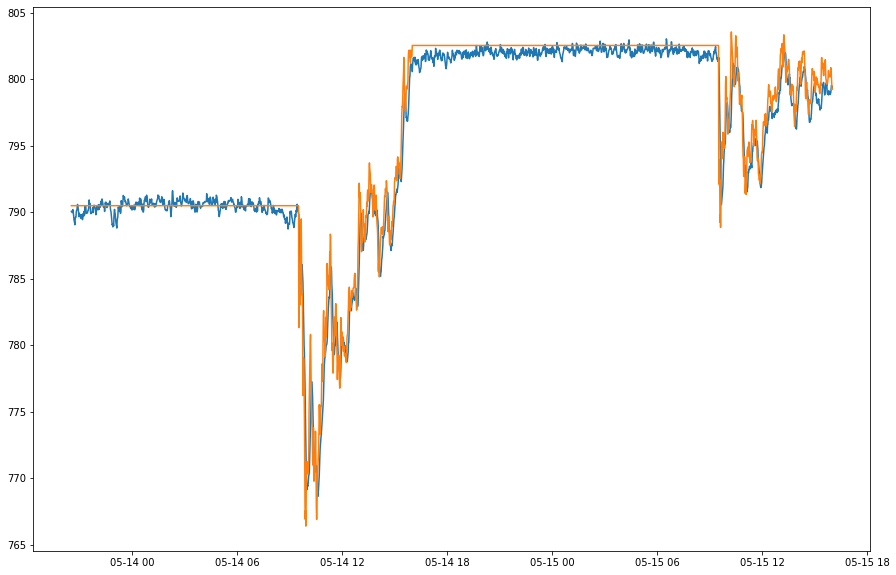

In [80]:
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], y_pred)
plt.plot(data.index[-2610:], y_actual)

 # LSTM
 - 64-dimensional single layer
 - activation=tanh
 - epochs = 20
 - batch size = 64
 - 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)
Epoch 1/20
56/56 - 7s - loss: 0.0252 - val_loss: 0.0065
Epoch 2/20
56/56 - 6s - loss: 0.0092 - val_loss: 0.0038
Epoch 3/20
56/56 - 6s - loss: 0.0049 - val_loss: 0.0032
Epoch 4/20
56/56 - 6s - loss: 0.0024 - val_loss: 0.0039
Epoch 5/20
56/56 - 6s - loss: 0.0015 - val_loss: 0.0031
Epoch 6/20
56/56 - 6s - loss: 0.0014 - val_loss: 0.0023
Epoch 7/20
56/56 - 6s - loss: 0.0012 - val_loss: 0.0017
Epoch 8/20
56/56 - 6s - loss: 0.0011 - val_loss: 0.0013
Epoch 9/20
56/56 - 6s - loss: 0.0011 - val_loss: 9.7207e-04
Epoch 10/20
56/56 - 6s - loss: 0.0010 - val_loss: 7.3957e-04
Epoch 11/20
56/56 - 6s - loss: 9.9377e-04 - val_loss: 5.7756e-04
Epoch 12/20
56/56 - 6s - loss: 9.6750e-04 - val_loss: 4.6810e-04
Epoch 13/20
56/56 - 6s - loss: 9.3816e-04 - val_loss: 3.9594e-04
Epoch 14/20
56/56 - 6s - loss: 9.0682e-04 - val_loss: 3.4945e-04
Epoch 15/20
56/56 - 6s - loss: 8.7586e-04 - val_loss: 3.1965e-04
Epoch 16/20
56/56 - 6s - loss: 8.4

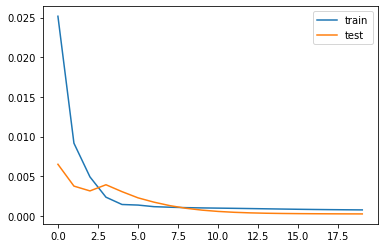

In [81]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [82]:
# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

Test RMSE: 1.233
Test RMSE/std_dev: 0.166
Test MAE: 0.754


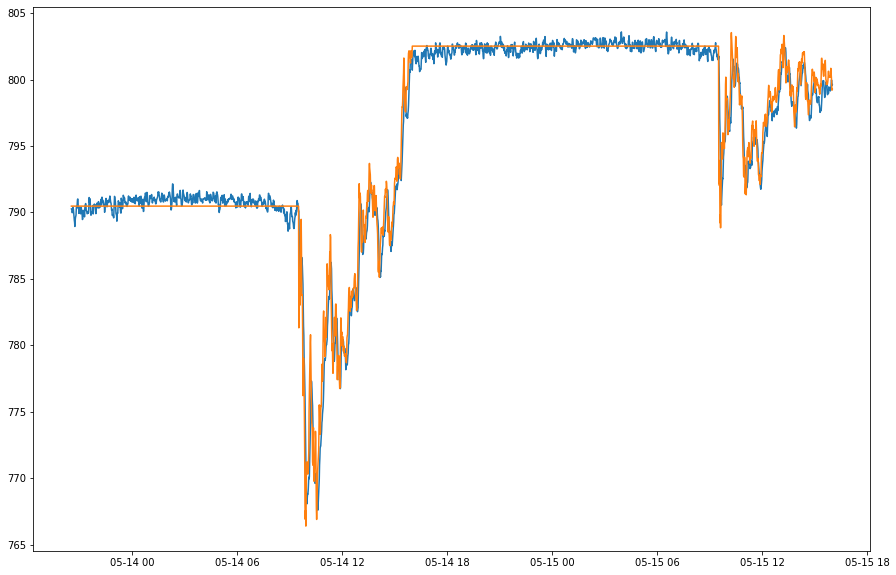

In [83]:
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], y_pred)
plt.plot(data.index[-2610:], y_actual)

# LSTM
- 64-dimensional single layer
- activation=tanh
- epochs = 20
- batch size = 64
- 2 nights and 3 days of predictioins

(3060, 1080) 3060 (3060,)
(3060, 270, 4) (3060,) (3090, 270, 4) (3090,)
Epoch 1/20
48/48 - 7s - loss: 0.0378 - val_loss: 0.0067
Epoch 2/20
48/48 - 6s - loss: 0.0041 - val_loss: 0.0072
Epoch 3/20
48/48 - 6s - loss: 0.0030 - val_loss: 0.0053
Epoch 4/20
48/48 - 6s - loss: 0.0021 - val_loss: 0.0038
Epoch 5/20
48/48 - 6s - loss: 0.0016 - val_loss: 0.0026
Epoch 6/20
48/48 - 6s - loss: 0.0014 - val_loss: 0.0019
Epoch 7/20
48/48 - 6s - loss: 0.0013 - val_loss: 0.0017
Epoch 8/20
48/48 - 6s - loss: 0.0012 - val_loss: 0.0017
Epoch 9/20
48/48 - 6s - loss: 0.0012 - val_loss: 0.0017
Epoch 10/20
48/48 - 6s - loss: 0.0012 - val_loss: 0.0017
Epoch 11/20
48/48 - 6s - loss: 0.0012 - val_loss: 0.0019
Epoch 12/20
48/48 - 6s - loss: 0.0013 - val_loss: 0.0020
Epoch 13/20
48/48 - 6s - loss: 0.0013 - val_loss: 0.0022
Epoch 14/20
48/48 - 6s - loss: 0.0014 - val_loss: 0.0023
Epoch 15/20
48/48 - 6s - loss: 0.0015 - val_loss: 0.0024
Epoch 16/20
48/48 - 6s - loss: 0.0017 - val_loss: 0.0024
Epoch 17/20
48/48 - 6s - 

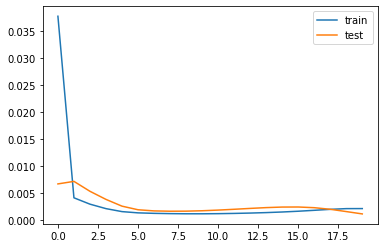

In [41]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 270
n_features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, n_hours, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_train_hours = len(data.loc[:'2020-05-13 08:00:00'])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/inv_y.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 2.582
Test RMSE/std_dev: 0.333
Test MAE: 2.298


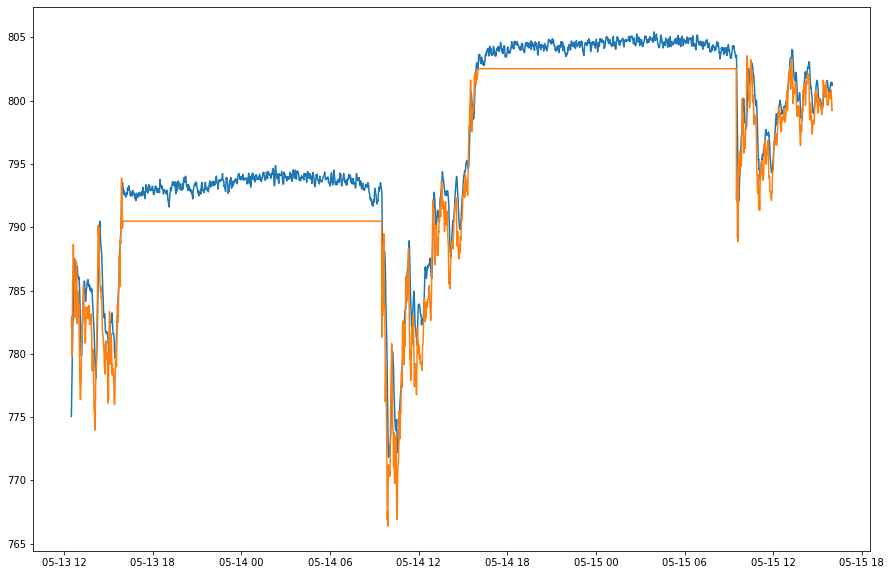

In [43]:
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-3090:], inv_yhat)
plt.plot(data.index[-3090:], inv_y)

# LSTM
- 64-dimensional single layer
- activation=relu
- epochs = 20
- batch size = 64
- 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)
Epoch 1/20
56/56 - 6s - loss: 0.0603 - val_loss: 0.0060
Epoch 2/20
56/56 - 6s - loss: 0.0095 - val_loss: 0.0040
Epoch 3/20
56/56 - 6s - loss: 0.0069 - val_loss: 0.0036
Epoch 4/20
56/56 - 6s - loss: 0.0040 - val_loss: 0.0031
Epoch 5/20
56/56 - 6s - loss: 0.0026 - val_loss: 0.0031
Epoch 6/20
56/56 - 5s - loss: 0.0022 - val_loss: 0.0026
Epoch 7/20
56/56 - 5s - loss: 0.0019 - val_loss: 0.0011
Epoch 8/20
56/56 - 5s - loss: 0.0013 - val_loss: 0.0014
Epoch 9/20
56/56 - 5s - loss: 0.0011 - val_loss: 4.4002e-04
Epoch 10/20
56/56 - 6s - loss: 8.0149e-04 - val_loss: 4.0283e-04
Epoch 11/20
56/56 - 6s - loss: 7.9983e-04 - val_loss: 4.1517e-04
Epoch 12/20
56/56 - 6s - loss: 8.1672e-04 - val_loss: 4.0981e-04
Epoch 13/20
56/56 - 6s - loss: 9.0135e-04 - val_loss: 4.4357e-04
Epoch 14/20
56/56 - 6s - loss: 9.4452e-04 - val_loss: 5.0660e-04
Epoch 15/20
56/56 - 6s - loss: 9.5003e-04 - val_loss: 5.6862e-04
Epoch 16/20
56/56 - 6s - loss:

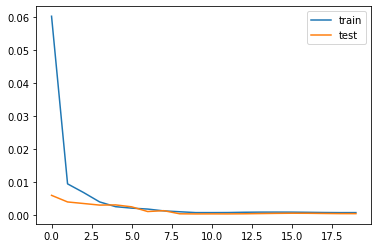

In [44]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 270
n_features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, n_hours, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_train_hours = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(64, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [45]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/inv_y.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 1.672
Test RMSE/std_dev: 0.226
Test MAE: 1.331


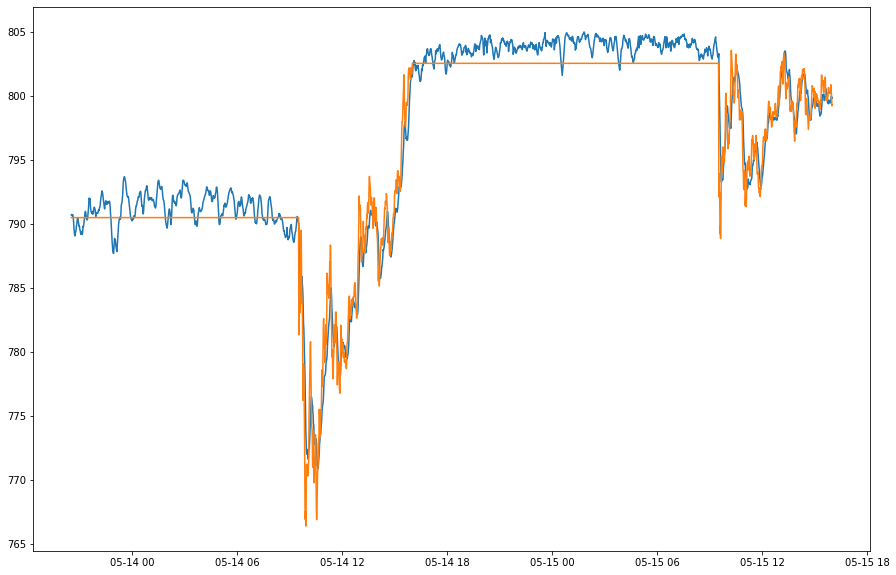

In [46]:
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], inv_yhat)
plt.plot(data.index[-2610:], inv_y)

# LSTM
- 128-dimensional layer, 64-dimensional layer
- activation=tanh
- 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)
Epoch 1/20
14/14 - 14s - loss: 0.0466 - val_loss: 0.0048
Epoch 2/20
14/14 - 13s - loss: 0.0204 - val_loss: 0.0093
Epoch 3/20
14/14 - 13s - loss: 0.0138 - val_loss: 0.0119
Epoch 4/20
14/14 - 13s - loss: 0.0037 - val_loss: 7.6477e-04
Epoch 5/20
14/14 - 14s - loss: 0.0013 - val_loss: 5.3970e-04
Epoch 6/20
14/14 - 13s - loss: 9.8932e-04 - val_loss: 4.3118e-04
Epoch 7/20
14/14 - 14s - loss: 0.0010 - val_loss: 4.4250e-04
Epoch 8/20
14/14 - 15s - loss: 0.0014 - val_loss: 4.3458e-04
Epoch 9/20
14/14 - 16s - loss: 0.0014 - val_loss: 4.5067e-04
Epoch 10/20
14/14 - 15s - loss: 0.0012 - val_loss: 4.4404e-04
Epoch 11/20
14/14 - 15s - loss: 0.0011 - val_loss: 4.3682e-04
Epoch 12/20
14/14 - 14s - loss: 0.0011 - val_loss: 4.6370e-04
Epoch 13/20
14/14 - 14s - loss: 0.0011 - val_loss: 5.1626e-04
Epoch 14/20
14/14 - 14s - loss: 0.0012 - val_loss: 5.8317e-04
Epoch 15/20
14/14 - 14s - loss: 0.0013 - val_loss: 6.6233e-04
Epoch 16/20
14/

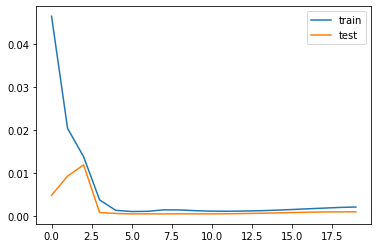

In [47]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 270
n_features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, n_hours, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_train_hours = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=256, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [48]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/inv_y.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 2.304
Test RMSE/std_dev: 0.311
Test MAE: 2.026


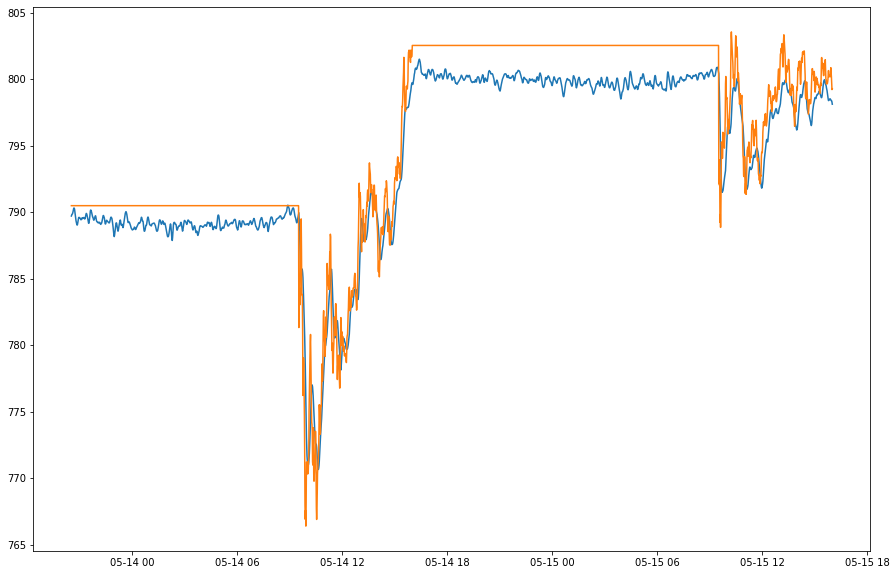

In [49]:
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], inv_yhat)
plt.plot(data.index[-2610:], inv_y)

# LSTM
- 100-dimensional single layer
- activation = tanh
- epochs = 20
- batch size = 64

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)
Epoch 1/20
56/56 - 10s - loss: 0.0277 - val_loss: 0.0038
Epoch 2/20
56/56 - 10s - loss: 0.0060 - val_loss: 0.0047
Epoch 3/20
56/56 - 10s - loss: 0.0029 - val_loss: 0.0047
Epoch 4/20
56/56 - 9s - loss: 0.0017 - val_loss: 0.0032
Epoch 5/20
56/56 - 9s - loss: 0.0016 - val_loss: 0.0022
Epoch 6/20
56/56 - 9s - loss: 0.0017 - val_loss: 0.0014
Epoch 7/20
56/56 - 9s - loss: 0.0017 - val_loss: 9.3526e-04
Epoch 8/20
56/56 - 9s - loss: 0.0017 - val_loss: 6.0969e-04
Epoch 9/20
56/56 - 10s - loss: 0.0015 - val_loss: 4.3981e-04
Epoch 10/20
56/56 - 9s - loss: 0.0013 - val_loss: 3.7256e-04
Epoch 11/20
56/56 - 9s - loss: 0.0012 - val_loss: 3.4568e-04
Epoch 12/20
56/56 - 9s - loss: 0.0011 - val_loss: 3.3134e-04
Epoch 13/20
56/56 - 9s - loss: 0.0010 - val_loss: 3.2420e-04
Epoch 14/20
56/56 - 9s - loss: 9.8280e-04 - val_loss: 3.2211e-04
Epoch 15/20
56/56 - 9s - loss: 9.7869e-04 - val_loss: 3.2204e-04
Epoch 16/20
56/56 - 9s - loss: 9.8

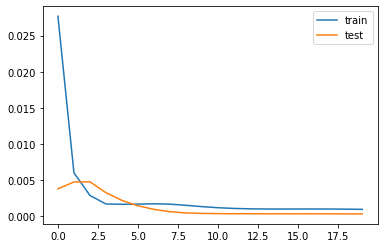

In [50]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 270
n_features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, n_hours, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_train_hours = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [51]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/inv_y.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 1.322
Test RMSE/std_dev: 0.178
Test MAE: 0.845


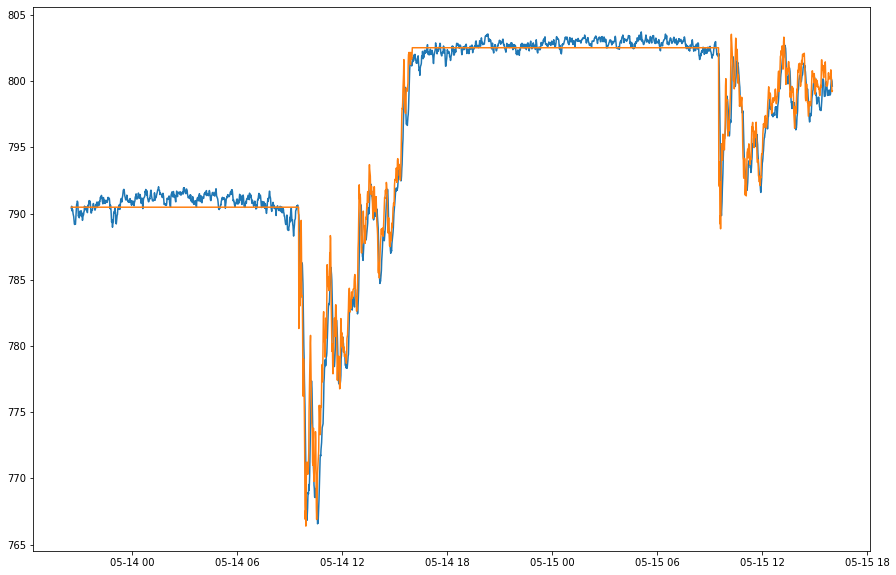

In [52]:
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], inv_yhat)
plt.plot(data.index[-2610:], inv_y)

## LSTM
- single 2D convolutional LSTM layer
- filters = 64
- kernel_size = (2,135)
- activation = relu
- epochs = 20
- batch size = 32

(3540, 1080) 3540 (3540,)
(3540, 1, 3, 90, 4) (3540,) (2610, 1, 3, 90, 4) (2610,)
Epoch 1/20
56/56 - 7s - loss: 0.0322 - val_loss: 0.0377
Epoch 2/20
56/56 - 6s - loss: 0.0671 - val_loss: 0.0179
Epoch 3/20
56/56 - 8s - loss: 0.0234 - val_loss: 0.0115
Epoch 4/20
56/56 - 7s - loss: 0.0291 - val_loss: 0.0121
Epoch 5/20
56/56 - 7s - loss: 0.0333 - val_loss: 0.0321
Epoch 6/20
56/56 - 8s - loss: 0.0267 - val_loss: 0.0092
Epoch 7/20
56/56 - 6s - loss: 0.0270 - val_loss: 0.0051
Epoch 8/20
56/56 - 7s - loss: 0.0254 - val_loss: 0.0100
Epoch 9/20
56/56 - 7s - loss: 0.0264 - val_loss: 0.0077
Epoch 10/20
56/56 - 7s - loss: 0.0232 - val_loss: 0.0057
Epoch 11/20
56/56 - 7s - loss: 0.0260 - val_loss: 0.0082
Epoch 12/20
56/56 - 11s - loss: 0.0259 - val_loss: 0.0079
Epoch 13/20
56/56 - 9s - loss: 0.0477 - val_loss: 0.0169
Epoch 14/20
56/56 - 8s - loss: 0.0295 - val_loss: 0.0195
Epoch 15/20
56/56 - 8s - loss: 0.0227 - val_loss: 0.0056
Epoch 16/20
56/56 - 8s - loss: 0.0229 - val_loss: 0.0103
Epoch 17/20
56

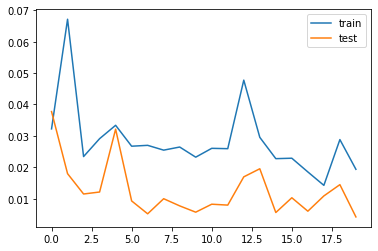

In [70]:
## load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 270
n_features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, n_hours, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_train_hours = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1 ,3, 90, 4))
test_X = test_X.reshape((test_X.shape[0], 1, 3, 90, 4))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3,90), activation='', input_shape=(train_X.shape[1], 3, 90, 4)))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [71]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
yhat = yhat.reshape(yhat.shape[0],1)
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/inv_y.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 4.846
Test RMSE/std_dev: 0.654
Test MAE: 3.327


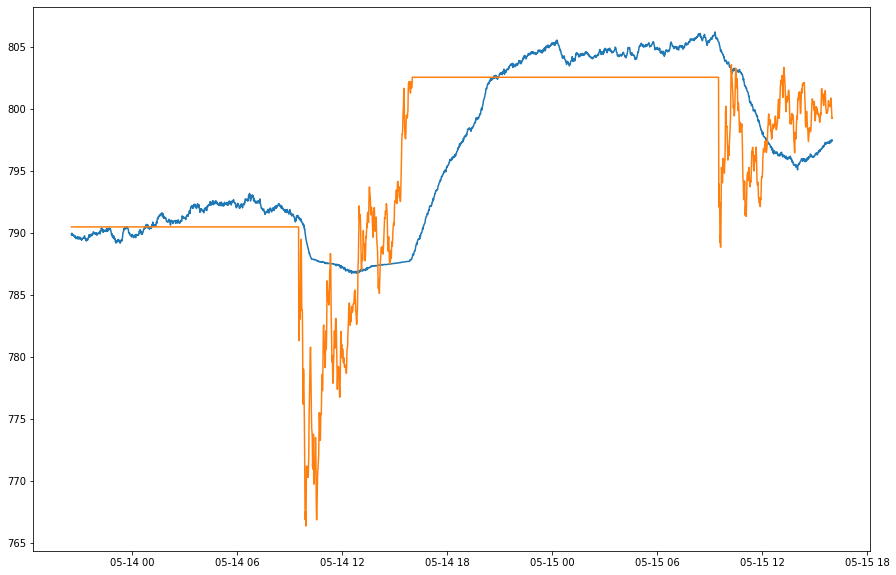

In [72]:
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], inv_yhat)
plt.plot(data.index[-2610:], inv_y)